<a href="https://colab.research.google.com/github/itsdevansh/CSI5386-NLP/blob/main/Assignment2/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [3]:
#Connecting to google drive to get datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "content/drive/MyDrive/Colab Notebooks/NLP-CSI5386"

In [5]:
#Loading files
train_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP-CSI5386/subtaskA_train_monolingual.jsonl', lines=True)
test_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP-CSI5386/subtaskA_test_monolingual.jsonl', lines=True)
gs_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP-CSI5386/subtaskA_gs_monolingual.jsonl', lines=True)

In [6]:
train_df.head(10)

,text,label,model,source,id
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4
5,How to Fix a Broken Window in a Wooden Frame\n...,1,chatGPT,wikihow,5
6,Publishing your WordPress theme on Themeforest...,1,chatGPT,wikihow,6
7,Building a Railroad Tie Retaining Wall can be ...,1,chatGPT,wikihow,7
8,Teaching your dog new tricks is a great way to...,1,chatGPT,wikihow,8
9,Remote Desktop is a useful tool that allows yo...,1,chatGPT,wikihow,9


In [7]:
test_df.head(10)

,text,id
0,"Today, many adults or teenage drivers are hook...",0
1,"The automobile, since its advent, has revoluti...",1
2,One policy that could potentially improve aca...,2
3,Title: Navigating the Road Ahead: The Case for...,3
4,Have you ever woken up in the morning and wish...,4
5,What do you think made the face on the side of...,5
6,Don't ask one time. Ask many people as you can...,6
7,"In recent years, the debate surrounding the us...",7
8,"In today's world, we are able to say a generou...",8
9,The electoral college has been around since 17...,9


In [8]:
gs_df.head(10)

,text,label,id
0,"Today, many adults or teenage drivers are hook...",0,0
1,"The automobile, since its advent, has revoluti...",1,1
2,One policy that could potentially improve aca...,1,2
3,Title: Navigating the Road Ahead: The Case for...,1,3
4,Have you ever woken up in the morning and wish...,0,4
5,What do you think made the face on the side of...,0,5
6,Don't ask one time. Ask many people as you can...,0,6
7,"In recent years, the debate surrounding the us...",1,7
8,"In today's world, we are able to say a generou...",0,8
9,The electoral college has been around since 17...,1,9


In [9]:
# Get insights about train data

Text(0.5, 1.0, 'Dsitribution of labels in training dataset')

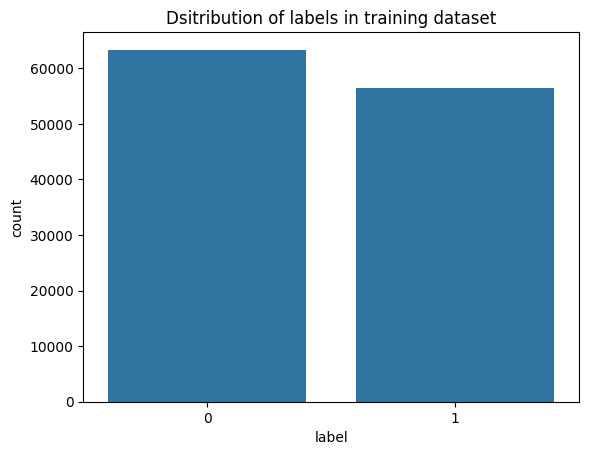

In [10]:
sns.barplot(x=train_df["label"].value_counts().index, y=train_df["label"].value_counts())
plt.title('Dsitribution of labels in training dataset')

The dataset is balanced concerning human generated text and ai generated text

Text(0.5, 1.0, 'Dsitribution of models in training dataset')

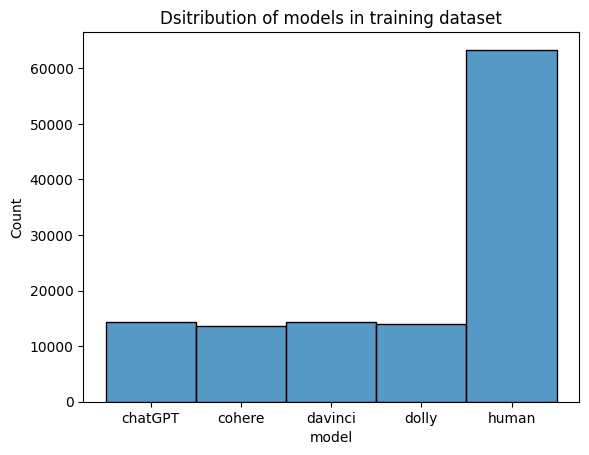

In [11]:
sns.histplot(train_df["model"])
plt.title('Dsitribution of models in training dataset')

In [12]:
#Split the dataset into train and validation sets
from sklearn.model_selection import train_test_split
X = train_df["text"]
y = train_df["label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Using DistilBert

In [13]:
#Load an pre-trained DistilBert tokenizer and model
#Got inspiration from https://github.com/Vidhi1290/LLM---Detect-AI-Generated-Text/blob/main/llm-detect-ai-generated-text.ipynb

from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, AdamW

# Load pre-trained DistilBert tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dist_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize inputs
encoded_train = tokenizer(list(X_train), return_tensors='pt', padding=True, truncation=True)
encoded_val = tokenizer(list(X_val), return_tensors='pt', padding=True, truncation=True)

# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [15]:
# Create DataLoaders - don't shuffle validation data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dist_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Define the optimizer
optimizer = AdamW(dist_model.parameters(), lr=2e-5)  # Slightly higher learning rate

# Training loop
epochs = 5  # Reduced epochs
for epoch in range(epochs):
    dist_model.train()
    total_loss = 0

    for batch in train_loader:
        # Move batch to device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = dist_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dist_model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Validation after each epoch
    dist_model.eval()
    val_preds = []
    val_true = []
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass with labels to get loss
            outputs = dist_model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    # Calculate validation metrics
    val_acc = accuracy_score(val_true, val_preds)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

In [ ]:
# Final evaluation on test data
dist_model.eval()
test_inputs = tokenizer(list(test_df["text"]), return_tensors='pt', padding=True, truncation=True)

# Move input tensors to device
test_inputs = {key: val.to(device) for key, val in test_inputs.items()}

with torch.no_grad():
    test_outputs = dist_model(**test_inputs)
    test_logits = test_outputs.logits
    test_preds = torch.argmax(test_logits, dim=1).cpu().numpy()

# Save predictions
predictions_file = pd.DataFrame({'id': test_df['id'], 'label': test_preds})
predictions_file.to_json('distilbert_predictions.jsonl', lines=True, orient="records")

# Optional: Save the model
torch.save(dist_model.state_dict(), 'distilbert_classifier.pt')

# Using T5

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

t5_tokenizer = T5Tokenizer.from_pretrained("t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-large")


In [ ]:
def prepare_t5_data(texts, labels = None, prefix = "classify: ") :

  #Add task prefix to input text
  input_texts= [prefix + text for text in texts]

  encoded_inputs = t5_tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True)

  if labels is not None :
    labels_texts = [str(label) for label in labels]
    encoded_targets = t5_tokenizer(labels_texts, return_tensors="pt", padding=True, truncation=True)

    dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], encoded_targets['input_ids'], encoded_targets['attention_mask'])
  else :
    dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])

  return dataset



In [ ]:
train_dataset_t5 = prepare_t5_data(X_train.tolist(), y_train.values)
val_dataset_t5 = prepare_t5_data(X_val.tolist(), y_val.values)

In [ ]:
#Create Dataloaders
train_loader_t5 = DataLoader(train_dataset_t5, batch_size=8, shuffle=True)
val_loader_t5 = DataLoader(val_dataset_t5, batch_size=8)

In [ ]:
#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t5_model.to(device)

In [ ]:
optimizer = AdamW(t5_model.parameters(), lr=1e-5)
epochs = 5

In [ ]:
for epoch in range(epochs):
    t5_model.train()
    total_loss = 0

    for batch in train_loader_t5:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        labels[labels == t5_tokenizer.pad_token_id] = -100

        optimizer.zero_grad()
        outputs = t5_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Calculate average training loss
    avg_train_loss = total_loss / len(train_loader_t5)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss:.4f}")

In [ ]:
#Validation set

t5_model.eval()
val_preds_t5 = []
val_true_t5 = []

with torch.no_grad():
    for batch in val_loader_t5:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = t5_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=2  # Short output for classification
            )
        # Decode predictions and convert to integers
        pred_texts = t5_tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Convert text predictions to integers
        batch_preds = [int(pred) if pred in ["0", "1"] else 0 for pred in pred_texts]

       # Extract true labels
        batch_labels = t5_tokenizer.batch_decode(
                labels, skip_special_tokens=True
            )
        batch_true = [int(label) if label in ["0", "1"] else 0 for label in batch_labels]

        val_preds_t5.extend(batch_preds)
        val_true_t5.extend(batch_true)

    val_acc = accuracy_score(val_true_t5, val_preds_t5)
    print(f"Validation accuracy: {val_acc:.4f}")


In [ ]:
# Testing on new data
def predict_with_t5(model, tokenizer, texts, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare test data
    test_dataset = prepare_t5_data(texts)
    test_loader = DataLoader(test_dataset, batch_size=16)

    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            # For inference batches (no labels)
            input_ids, attention_mask = [b.to(device) for b in batch]

            # Generate text outputs
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=2
            )

            # Decode and convert to integers
            pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            batch_preds = [int(pred) if pred in ["0", "1"] else 0 for pred in pred_texts]

            all_preds.extend(batch_preds)

    return all_preds

# Make predictions on test data
test_texts = list(test_df["text"])
test_preds = predict_with_t5(t5_model, t5_tokenizer, test_texts, device)

# Save predictions
predictions_file = pd.DataFrame({'id': test_df['id'], 'label': test_preds})
predictions_file.to_csv('t5_predictions.csv', index=False)

In [ ]:
#Testing Data

test_inputs = t5_tokenizer(list(test_df["text"]), return_tensors='pt', padding=True, truncation=True)

with torch.no_grad():
    test_outputs = t5_model(**test_inputs)
    test_logits = test_outputs.logits
    test_preds = torch.argmax(test_logits, dim=1).cpu().numpy()

predictions_file = pd.DataFrame({'id': test_df['id'], 'label': test_preds})
predictions_file.to_json('t5_predictions.jsonl', lines = True, orient = "records")